# 01 - Exploratory Data Analysis

# Introduction

In this project, I will be attempting to classify a dataset of tweets into one of three categories: non-offensive, offensive but without hate speech, and hate speech. In particular, I will explore four different methods of classification:
- Multinomial Naive Bayes using sparse word count vectors
- Artificial neural network using corpus-trained word embedding vectors
- Convolutional neural network using corpus-trained word embedding vectors
- Convolutional neural network using pre-trained word embedding vectors

The dataset itself was obtained from [CrowdFlower](https://www.crowdflower.com/data/hate-speech-identification/), a data consulting firm that crowdsourced the labeling of roughly 15,000 normal, offensive, and hateful speech.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style = 'whitegrid')

data_directory = os.path.join('..','data','')
csv_path = os.path.join(data_directory, 'twitter_hate_speech.csv')
df_orig = pd.read_csv(csv_path, engine = 'python', delimiter = ',')

# Understanding the data
Except for a short blurb on the CrowdFlower website describing the data:
> "Contributors viewed short text and identified if it a) contained hate speech, b) was offensive but without hate speech, or c) was not offensive at all. Contains nearly 15K rows with three contributor judgments per text string."

there exists no documentation regarding how to interpret the structure of the dataset or the methodology behind obtaining and labeling the tweets.

In [2]:
print('The dataset contains {} rows and {} columns:'.format(df_orig.shape[0], df_orig.shape[1]))

for name in df_orig.columns:
    print('\t',name)

The dataset contains 14509 rows and 20 columns:
	 _unit_id
	 _golden
	 _unit_state
	 _trusted_judgments
	 _last_judgment_at
	 does_this_tweet_contain_hate_speech
	 does_this_tweet_contain_hate_speech:confidence
	 _created_at
	 orig__golden
	 orig__last_judgment_at
	 orig__trusted_judgments
	 orig__unit_id
	 orig__unit_state
	 _updated_at
	 orig_does_this_tweet_contain_hate_speech
	 does_this_tweet_contain_hate_speech_gold
	 does_this_tweet_contain_hate_speech_gold_reason
	 does_this_tweet_contain_hate_speechconfidence
	 tweet_id
	 tweet_text


In [3]:
# columns re-named for convenience
df_orig.columns = ['id', 'golden','state', 'trusted_judgements','last_judgment','is_hate_speech','confidence',
                   'created','orig_golden','orig_last_judgement','orig_trusted_judgements','orig_id','orig_state',
                   'updated','orig_is_hate_speech','is_hate_speech_gold','reason','confidence2','id2','text']

In [4]:
df_orig.head(3)

,id,golden,state,trusted_judgements,last_judgment,is_hate_speech,confidence,created,orig_golden,orig_last_judgement,orig_trusted_judgements,orig_id,orig_state,updated,orig_is_hate_speech,is_hate_speech_gold,reason,confidence2,id2,text
0,853718217,True,golden,86,NaN,The tweet uses offensive language but not hate...,0.6013,NaN,True,NaN,0.0,615561535.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,1.666196e+09,Warning: penny boards will make you a faggot
1,853718218,True,golden,92,NaN,The tweet contains hate speech,0.7227,NaN,True,NaN,0.0,615561723.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,4.295121e+08,Fuck dykes
2,853718219,True,golden,86,NaN,The tweet contains hate speech,0.5229,NaN,True,NaN,0.0,615562039.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,3.956238e+08,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandon...


### Significant amounts of missing data in many features
More than half the columns immediately appear to be unusable due to having almost no data.

In [5]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14509 entries, 0 to 14508
Data columns (total 20 columns):
id                         14509 non-null int64
golden                     14509 non-null bool
state                      14509 non-null object
trusted_judgements         14509 non-null int64
last_judgment              14442 non-null object
is_hate_speech             14509 non-null object
confidence                 14509 non-null float64
created                    0 non-null float64
orig_golden                67 non-null object
orig_last_judgement        0 non-null float64
orig_trusted_judgements    67 non-null float64
orig_id                    67 non-null float64
orig_state                 67 non-null object
updated                    0 non-null float64
orig_is_hate_speech        67 non-null object
is_hate_speech_gold        67 non-null object
reason                     0 non-null float64
confidence2                67 non-null float64
id2                        14509 non-null 

### 'id' and 'id2'
The ID's of each tweet are indeed unique. Curiously, this does not hold for id2, which has only 63 unique values despite having no missing data. Without being able to discren its meaning, id2 is of no use.

In [6]:
print('Unique values \'id\':', len(df_orig.id.unique()))
print('Unique values \'id2\':', len(df_orig.id2.unique()))
print('Value counts \'id2\':')
print(df_orig.id2.value_counts().head(10))

Unique values 'id': 14509
Unique values 'id2': 63
Value counts 'id2':
6.790000e+17    7321
6.800000e+17    6227
6.780000e+17     486
6.770000e+17     371
6.760000e+17      37
1.488430e+09       3
2.583138e+09       2
3.956238e+08       2
2.038160e+08       2
4.334475e+08       2
Name: id2, dtype: int64


### 'trusted_judments'
This feature appears to indicate the number of people that judged each tweet. We see that the vast majority of tweets were judged by three people, so this feature can also be excluded.

In [9]:
df_orig.trusted_judgements.value_counts()

3     14442
91        8
93        7
90        7
88        7
94        6
92        6
95        5
87        5
89        5
86        3
98        3
96        2
85        1
84        1
97        1
Name: trusted_judgements, dtype: int64

### 'golden' and 'state'
It looks like the two features are redundant. If a tweet's "state" is golden, then "golden" is also true. Furthermore, a tweet is "golden" if more than three people judged it, but given that so few tweets meet this criteria, it's hard to see how this will be helpful.

In [10]:
print(df_orig.golden.value_counts(),'\n')
print(df_orig.state.value_counts(),'\n')
print(len(df_orig[(df_orig.golden == True) & (df_orig.state == 'golden')]))

False    14442
True        67
Name: golden, dtype: int64 

finalized    14442
golden          67
Name: state, dtype: int64 

67


In [11]:
# non-golden tweets are always judged by only three people
df_orig[df_orig.golden == False].trusted_judgements.value_counts()

3    14442
Name: trusted_judgements, dtype: int64

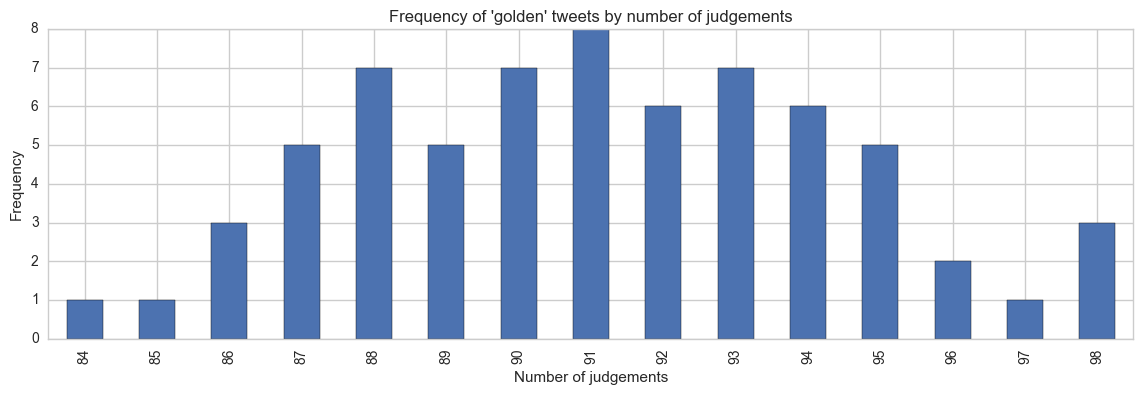

In [12]:
plt.figure(figsize = (14,4))
ax = df_orig[df_orig.golden == True].trusted_judgements.value_counts().sort_index().plot(kind = 'bar')
___ = ax.set(xlabel = 'Number of judgements', ylabel = 'Frequency',
      title = 'Frequency of \'golden\' tweets by number of judgements')

### 'confidence'
Without a codebook, it's hard to know for sure what confidence means, but it appears unrelated to whether a tweet is golden. A reasonable guess here is that it measures the extent of agreement amongst judgements. For example, if all judgements agree that a particular tweet is hateful, then that tweet would be labeled with a confidence of 1.0.

In [13]:
print('Average confidence of \'golden\' tweets:', df_orig[df_orig.golden == True].confidence.mean())
print('Average confidence of \'non-golden\' tweets:', df_orig[df_orig.golden == False].confidence.mean())

Average confidence of 'golden' tweets: 0.8348373134328358
Average confidence of 'non-golden' tweets: 0.8659881664589465


In [14]:
print('Average num judgements of \'confident\' tweets:', df_orig[df_orig.confidence == 1].trusted_judgements.mean())
print('Average num judgements of \'non-confident\' tweets:', df_orig[df_orig.golden != 1].trusted_judgements.mean())

Average num judgements of 'confident' tweets: 3.1770983879933294
Average num judgements of 'non-confident' tweets: 3.0


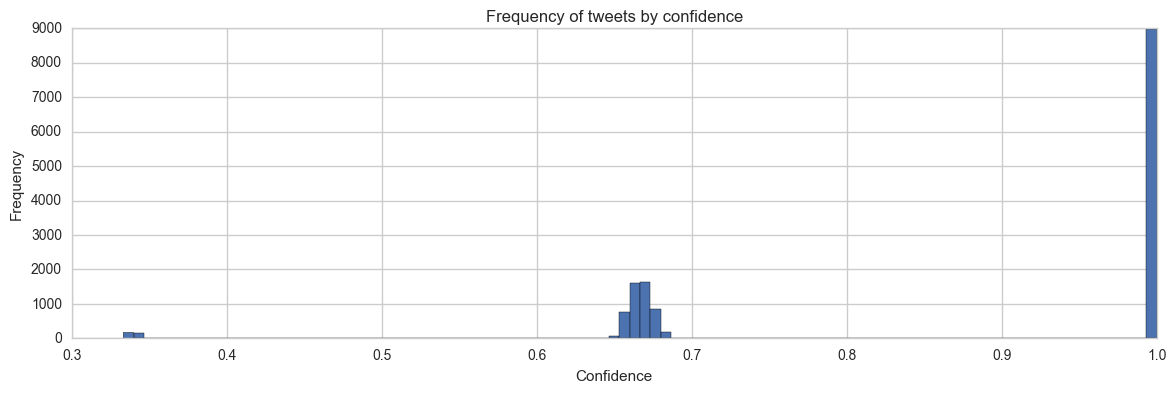

In [15]:
plt.figure(figsize = (14,4))
___ = df_orig.confidence.hist(bins = 100).set(title = 'Frequency of tweets by confidence', xlabel = 'Confidence',
                                       ylabel = 'Frequency')

# Data cleaning
### Drop sparse columns

First, we drop all columns that have only 67 or less non-null values. Since ID's are unique, they will be a useful way of indexing each tweet.

In [16]:
df = df_orig.dropna(thresh = 68, axis = 'columns')
df = df.set_index('id')

In [17]:
df.head(3)

,golden,state,trusted_judgements,last_judgment,is_hate_speech,confidence,id2,text
id,,,,,,,,
853718217,True,golden,86,NaN,The tweet uses offensive language but not hate...,0.6013,1.666196e+09,Warning: penny boards will make you a faggot
853718218,True,golden,92,NaN,The tweet contains hate speech,0.7227,4.295121e+08,Fuck dykes
853718219,True,golden,86,NaN,The tweet contains hate speech,0.5229,3.956238e+08,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandon...


### Recode hate speech classifications
Next, we re-encode the hate speech labels to something more manageable:
- 0: Does not contain offensive language
- 1: Contains offensive language but not hate speech
- 2: Contains hate speech

All columns except for 'is_hate_speech' and 'text' are also dropped.

In [18]:
df = df[['text','is_hate_speech','confidence']]
categories = df.is_hate_speech.unique()
print(categories)
df['is_hate_speech'] = df['is_hate_speech'].replace(categories, [1,2,0])

['The tweet uses offensive language but not hate speech'
 'The tweet contains hate speech' 'The tweet is not offensive']


# The data is somewhat unbalanced
Half the tweets have been classified as non-offensive while the remaining tweets comprise an uneven mixture of those classified as offensive and those classified as hate speech.

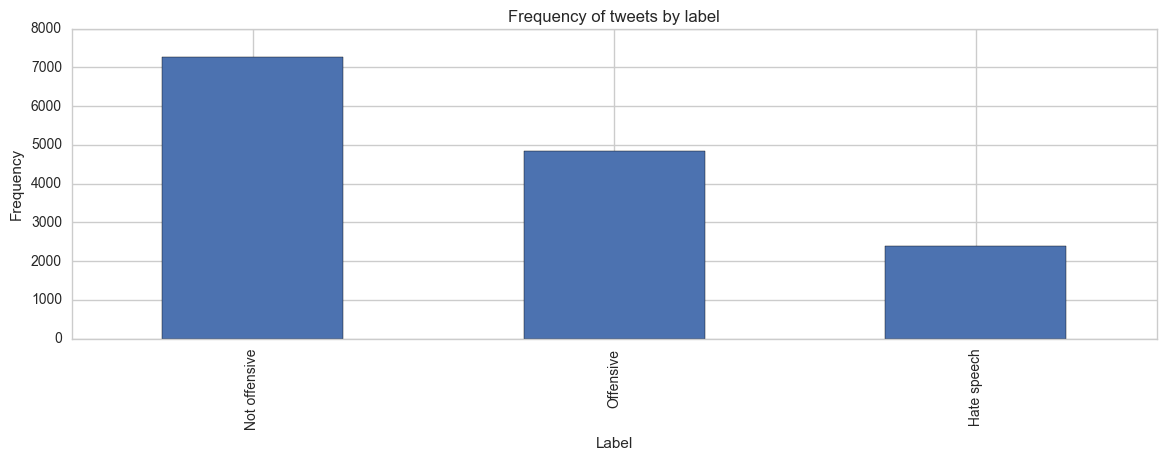

In [20]:
plt.figure(figsize = (14,4))
ax = df.is_hate_speech.value_counts().plot(kind = 'bar')
ax.set(title = 'Frequency of tweets by label', xlabel = 'Label', ylabel = 'Frequency')
ax.set_xticklabels(['Not offensive', 'Offensive',' Hate speech'])

# Cleaning up the text
The tweets contained within this dataset have been untouched, and as such, require heavy cleaning prior to any form of analysis. In particular, user handles, hashtags, urls, emoticons, and many more issues will need to be addressed.

In [93]:
pd.options.display.max_colwidth = 140
df.head(5)

,text,is_hate_speech
id,,
853718217,Warning: penny boards will make you a faggot,1
853718218,Fuck dykes,2
853718219,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandonernandez @bootyacid at least i dont look like jefree starr faggot,2
853718220,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkillah Is a fag"" jackie jealous"" Neeeee",2
853718221,@Zhugstubble You heard me bitch but any way I'm back th texas so wtf u talking about bitch ass nigga,1


In [16]:
with open('../data/all_tweets.txt', 'wt') as file_out:
    for index in df.index:
        tweet = df.loc[index,'text'].replace('\n','\\n') + '\n'
        file_out.write(tweet)

In [95]:
with open('../data/all_tweets.txt', 'rt') as file_in:
    corpus = file_in.read()

### How much of the corpus is comprised of unhelpful tokens?

In [100]:
import re

handles = re.findall(r'@\w+\s', corpus)
num_handles = len(handles)
num_tokens = len(corpus.split())
print('{:2.2f}% of tokens are user handles.'.format(num_handles / num_tokens * 100))

4.08% of tokens are user handles.


In [101]:
urls = re.findall(r'https?://\S+', corpus)
num_urls = len(urls)
print('{:2.2f}% of tokens are urls.'.format(num_urls / num_tokens * 100))

1.84% of tokens are urls.


In [102]:
hashtags = re.findall(r'#\S*', corpus)
num_hashtags = len(hashtags)
print('{:2.2f}% of tokens are hashtags.'.format(num_hashtags / num_tokens * 100))

1.14% of tokens are hashtags.


In [103]:
other = re.findall(r'[�!$%^&*\(\)]\S*', corpus)
num_other = len(other)
print('{:2.2f}% of tokens are miscellaneous.'.format(num_other / num_tokens * 100))

2.96% of tokens are miscellaneous.


Tokens like user handles, urls, and special symbols are of limited usefulness because they contribute little to the content of a tweet yet threaten to explode the vocabulary of a corpus. To prevent this, we replace such tokens with a common placeholder.

The question of hashtags is trickier: some users include them at the end of a tweet like a normal tag, but others may choose to use a hashtag in place of a word to use limited characters more efficiently. For this reason, only the '#' is removed from a hashtag, and a separate process will determine whether the resulting token is worth keeping.

In [104]:
# replace unhelpful tokens with placeholders
corpus_clean = re.sub(r'@\w+.\s', 'TWITTER_HANDLE ', corpus)
corpus_clean = re.sub(r'#|&|\(|\)|\"', ' ', corpus_clean)
corpus_clean = re.sub(r'https?://\S+', 'URL ', corpus_clean)
corpus_clean = re.sub(r'�\S*\d*','UNDEF', corpus_clean)
corpus_clean[:1000]

"Warning: penny boards will make you a faggot\nFuck dykes\nTWITTER_HANDLE TWITTER_HANDLE TWITTER_HANDLE TWITTER_HANDLE TWITTER_HANDLE at least i dont look like jefree starr faggot\n TWITTER_HANDLE  TWITTER_HANDLE TWITTER_HANDLE Is a fag  jackie jealous  Neeeee\nTWITTER_HANDLE You heard me bitch but any way I'm back th texas so wtf u talking about bitch ass nigga\nTWITTER_HANDLE your a dirty terrorist and your religion is a fucking joke, you go around screaming Allah akbar doing terrorist shit. Dirty faggot.\nRT TWITTER_HANDLE TWITTER_HANDLE looking like faggots?\nWell I thought you knew actually RT TWITTER_HANDLE Man why y'all didn't tell me I was a dick riding ass faggot? Y'all not real   128557;  128557;  128557;  128557;  128557;  128557;\nTWITTER_HANDLE I know. It was a joke, faggot.\nI'm tired of people saying I look like my brother  amp; calling me Deondre' like serious Succ My Ass fag asses\n VoteBlue2014 Yeah. CUZ 8 million people in faggot ass  newyork are  chickenshit JEWS gt

### Lemmatization
Beyond simply replacing semantically meaningless tokens with placeholders, the analysis of the corpus may benefit from the lemmatization of the remaining tokens. This involves removing the inflectional endings of words so that they can be transformed into their base word. For example, 'is', 'was', and 'am' would all map to 'be', and 'jumping', 'jumped', and 'jumps' would all map to 'jump.'

This step is usually less important when dealing with analyses that involve word vector embeddings, as words with the same base and semantic meaning will likely result in similar vectors, but because a corpus of less than 15,000 tweets is incredibly small for training word vectors, reducing the vocabulary through lemmatization is necessary.

In [106]:
import spacy
nlp = spacy.load('en')
corpus_parsed = nlp(corpus_clean)
corpus_normalized = [token.lemma_ for token in corpus_parsed]

The output below shows the extent to which the corpus' vocabulary has been reduced following cleaning and lemmatization.

In [107]:
print('Unique tokens before cleaning:', pd.Series(corpus.split()).unique().size)
print('Unique tokens after cleaning:', pd.Series(corpus_clean.split()).unique().size)
print('Unique tokens after normalizing:', pd.Series(corpus_normalized).unique().size)

Unique tokens before cleaning: 42593
Unique tokens after cleaning: 29763
Unique tokens after normalizing: 16527


In [108]:
unique_normalized = pd.Series(corpus_normalized).unique()
unique_normalized = pd.Series(unique_normalized)

data = [(token.orth_, token.ent_type_, token.ent_iob_, token.prob, token.is_stop, token.is_punct, token.is_space,
        token.like_num, token.is_oov) for token in corpus_parsed]
df_corpus = pd.DataFrame(data, columns = ['token','ent_type','iob','prob','is_stop','is_punct','is_space',
                        'like_num','is_oov'])

In [109]:
oov_rate = sum(df_corpus.is_oov) / len(df_corpus)
print('{:2.2f}% of tokens from cleaned corpus are out of vocabulary.'.format(oov_rate * 100))

8.78% of tokens from cleaned corpus are out of vocabulary.


In [28]:
with open('../data/all_tweets_cleaned.txt','wt') as file_out:
    file_out.write(corpus_parsed.text)

# Latent Dirichlet Allocation
LDA is a popular technique for discovering topics within a corpus, however given the smallness of the current corpus and the natural shortness of each tweet, the results were not particularly good.

In [122]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import LineSentence

import pyLDAvis
import pyLDAvis.gensim
import warnings
import _pickle as pickle

def punct_space(token):
    return token.is_space or token.is_punct

def line_tweet(filename):
    with open(filename, 'rt') as file_in:
        for tweet in file_in:
            yield tweet.replace('\\n','\n')
            
def lemmatized_sentence_corpus(filename):
    for parsed_tweet in nlp.pipe(line_tweet(filename), batch_size = 1000, n_threads = 2):
        for sentence in parsed_tweet.sents:
            yield ' '.join([token.lemma_ for token in sentence if not punct_space(token)])

In [140]:
with open('../data/unigram_sentences.txt','wt') as file_out:
    for sentence in lemmatized_sentence_corpus('../data/all_tweets_cleaned.txt'):
        file_out.write(sentence + '\n')

unigram_sentences = LineSentence('../data/unigram_sentences.txt')

with open('../data/transformed_tweets_all.txt','wt') as file_out:
    for parsed_tweet in nlp.pipe(line_tweet('../data/unigram_sentences.txt'), batch_size = 1000, n_threads = 2):
        unigram_tweet = [token.lemma_ for token in parsed_tweet if not punct_space(token)]
        unigram_tweet = ' '.join(unigram_tweet)
        file_out.write(unigram_tweet + '\n')
        
unigram_tweets = LineSentence('../data/trigram_transformed_tweets_all.txt')
unigram_dictionary = Dictionary(unigram_tweets)

unigram_dictionary.filter_extremes(no_below = 10, no_above = 0.4)
unigram_dictionary.save('../data/trigram_dictionary')

In [125]:
def unigram_bow_generator(filepath):
    for review in LineSentence(filepath):
        yield unigram_dictionary.doc2bow(review)
        
MmCorpus.serialize('../data/unigram_bow_corpus.mm',
                   unigram_bow_generator('../data/transformed_tweets_all.txt'))
unigram_bow_corpus = MmCorpus('../data/unigram_bow_corpus.mm')

with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        lda = LdaMulticore(unigram_bow_corpus, num_topics=5, id2word=unigram_dictionary, workers=1)
        lda.save('../data/lda_model')

In [131]:
def explore_topic(topic_number, topn=25):
        
    print('{:20} {}'.format('term', 'frequency') + '\n')

    for term, frequency in lda.show_topic(topic_number, topn=25):
        print('{:20} {:.3f}'.format(term, round(frequency, 3)))

In [142]:
explore_topic(topic_number=1)

term                 frequency

nigga                0.046
fuck                 0.045
bitch                0.040
twitter_handle       0.037
-PRON-               0.033
white                0.023
kike                 0.020
faggot               0.020
ass                  0.018
know                 0.015
wit                  0.011
man                  0.009
shut                 0.009
lol                  0.009
love                 0.009
u                    0.008
nigger               0.008
url                  0.008
girl                 0.007
shit                 0.007
fag                  0.007
wanna                0.007
school               0.007
like                 0.007
come                 0.006


# Word Vector Embedding 
Word vector embeddings in which each word is represented by a 100-dimensional vector show more promising results. Roughly speaking, the word vectors are trained according to the context of the words surrounding them, but given the small dataset and diverse grammar of tweets, odd relationships frequently appear.

In [159]:
from gensim.models import Word2Vec

unigram_sentences = LineSentence('../data/unigram_sentences.txt')
tweet2vec = Word2Vec(unigram_sentences, size=100, window=5,
                        min_count=20, sg=1, workers=1)
tweet2vec.save('../data/word2vec_model')

for i in range(1,12):
    tweet2vec.train(unigram_sentences, total_examples=tweet2vec.corpus_count, epochs=11)
    tweet2vec.save('../data/word2vec_model')
    
tweet2vec.init_sims()
print('{:,} terms in the tweet2vec vocabulary.'.format(tweet2vec.corpus_count))

20,550 terms in the tweet2vec vocabulary.


In [160]:
def get_related_terms(token, topn=10):
    for word, similarity in tweet2vec.most_similar(positive=[token], topn=topn):
        print('{:20} {}'.format(word, round(similarity, 3)))

The related terms below show that the vector embeddings, while good, also have room for improvement. That 'etc' is more similar to 'terrorist' than 'isis' is curious, as are the similarities of other pairs of related terms. In previous versions of this process, I had performed phrase modeling prior to training word vectors, generating bigrams and trigrams for sets of words that frequently appear together (like counting 'ice_cream' as a single token rather than two separate tokens). While this may have worked for larger texts, for this corpus it significantly degraded the embedding quality.

In [161]:
get_related_terms('trump')

donald               0.688
muslim               0.399
jew                  0.38
america              0.379
vote                 0.365
fact                 0.352
word                 0.351
short                0.341
win                  0.337
hillary              0.334


In [162]:
get_related_terms('terrorist')

islam                0.462
court                0.416
federal              0.405
religion             0.394
report               0.39
muslim               0.388
etc                  0.381
police               0.38
anti                 0.368
isis                 0.358


In [163]:
get_related_terms('faggot')

queer                0.485
fag                  0.45
gay                  0.412
guy                  0.396
twitter_handle       0.394
fuck                 0.376
cry                  0.368
nigger               0.367
twitter              0.366
bitch                0.365


In [176]:
get_related_terms('black')

racist               0.405
white                0.358
rap                  0.351
woman                0.35
kill                 0.346
cop                  0.34
person               0.324
man                  0.32
muslims              0.317
idiot                0.312


In [164]:
get_related_terms('rape')

say                  0.406
rap                  0.406
woman                0.378
offend               0.367
muslim               0.366
anti                 0.365
know                 0.346
etc                  0.345
issue                0.336
marry                0.335


In [280]:
get_related_terms('christmas')

christma             0.471
eve                  0.458
merry                0.407
gift                 0.355
g                    0.344
spend                0.333
this                 0.33
holiday              0.33
ill                  0.327
recovery             0.326


### Word Algebra
Here, we simply add or subtract word vectors and then display in order the most similar tokens to the result. In general, additions tend to make sense, but subtractions not so much.

In [151]:
def word_algebra(add=[], subtract=[], topn=1):
    answers = tweet2vec.most_similar(positive=add, negative=subtract, topn=topn)
    for term, similarity in answers:
        print(term)

In [286]:
word_algebra(add=['muslim', 'terrorist'])

islam


In [295]:
word_algebra(add=['muslim'], subtract=['terrorist'], topn=5)

place
insult
thank
vote
blame


In [331]:
word_algebra(add=['obama', 'trump'])

donald


In [299]:
word_algebra(add=['obama'], subtract =['trump'], topn=5)

president
hard
shop
secret
obj


In [305]:
word_algebra(add=['obama','hillary'])

president


In [304]:
word_algebra(subtract=['obama','hillary'])

dead


In [313]:
word_algebra(add=['boy'], subtract=['boy'])

-PRON-


In [328]:
word_algebra(add=['girl','girl'])

boy


In [327]:
word_algebra(add=['boy','boy'])

girl


In [330]:
word_algebra(add=['black','white'])

trash


# Word Graph
Finally, we attempt a plot of the 100 most frequent tokens through dimensionality reduction using t-SNE, taking care to exclude some of random-seeming and noisy ones. The resulting projection does not reveal much by way of structure.

In [333]:
from collections import Counter

with open('../data/unigram_sentences.txt', 'rt') as file_in:
    trigram_parsed = nlp(file_in.read())

In [343]:
exclude = ['\n', '\'s', 'u', 'amp', 'ur', '2', '1', 'r', 'ya', 'yeah', 'ne', 'm']
words = [token.text for token in trigram_parsed if token.is_stop != True and token.is_punct != True \
         and token.is_oov != True and token.text not in exclude and token.is_digit != True]
word_freq = Counter(words)
num_words = 100
top_words = [pair[0] for pair in word_freq.most_common(num_words)]

In [344]:
wv_matrix = np.zeros([num_words, tweet2vec.vector_size])
for index, word in enumerate(top_words):
    wv_matrix[index, :] = tweet2vec[word]

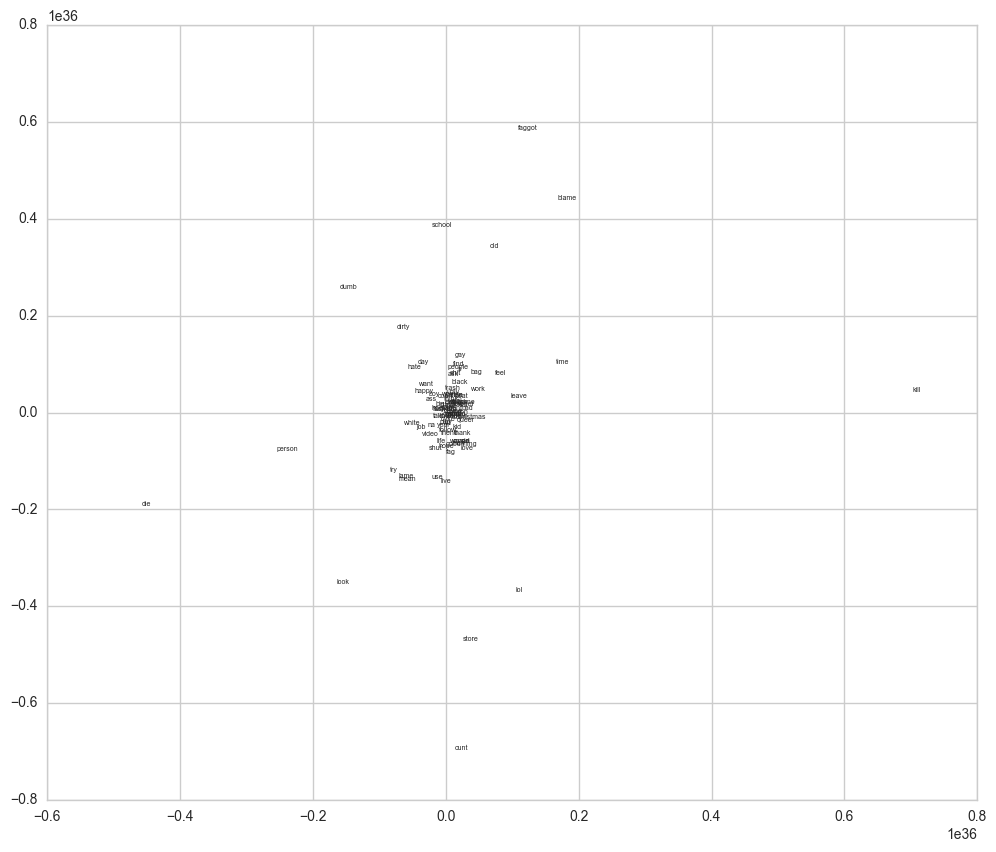

In [350]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, early_exaggeration=4, perplexity=75, learning_rate = 40)

wv_matrix_2d = tsne.fit_transform(wv_matrix)

plt.figure(figsize = (12, 10))
plt.scatter(wv_matrix_2d[:,0], wv_matrix_2d[:,1], s = 0)

for word, x, y in zip(top_words, wv_matrix_2d[:,0], wv_matrix_2d[:,1]):
    plt.annotate(word, xy = (x, y), xytext = (0, 0), textcoords = 'offset points', size = 5)